In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import umap

# Méthode de sklearn:
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

c:\Users\alqui\Challenge_QRT\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Récupération des données

In [2]:
train_home_team_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Train_Data/train_home_team_statistics_df.csv")
train_home_player_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Train_Data/train_home_player_statistics_df.csv")
train_away_player_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Train_Data/train_away_player_statistics_df.csv")
train_away_team_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Train_Data/train_away_team_statistics_df.csv")

train_scores = pd.read_csv("C:/Users/alqui/Downloads/Y_train_1rknArQ.csv", index_col=0)

train_home_team = train_home_team_statistics_df.iloc[:,3:]
train_away_team = train_away_team_statistics_df.iloc[:,3:]
train_home_player = train_home_player_statistics_df
train_away_player = train_away_player_statistics_df

train_home_team.columns = 'HOME_' + train_home_team.columns
train_away_team.columns = 'AWAY_' + train_away_team.columns
train_home_player.columns = 'HOME_' + train_home_player.columns
train_away_player.columns = 'AWAY_' + train_away_player.columns

train_team_data =  pd.concat([train_home_team,train_away_team],join='inner',axis=1)
train_player_data =  pd.concat([train_home_player,train_away_player],join='inner',axis=1)
train_data =  pd.concat([train_team_data,train_player_data],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [3]:
test_home_team_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Test_Data/test_home_team_statistics_df.csv")
test_home_player_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Test_Data/test_home_player_statistics_df.csv")
test_away_player_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Test_Data/test_away_player_statistics_df.csv")
test_away_team_statistics_df = pd.read_csv("C:/Users/alqui/Downloads/Test_Data/test_away_team_statistics_df.csv")

test_home_team = test_home_team_statistics_df.iloc[:,1:]
test_away_team = test_away_team_statistics_df.iloc[:,1:]
test_home_player = test_home_player_statistics_df
test_away_player = test_away_player_statistics_df

test_home_team.columns = 'HOME_' + test_home_team.columns
test_away_team.columns = 'AWAY_' + test_away_team.columns
test_home_player.columns = 'HOME_' + test_home_player.columns
test_away_player.columns = 'AWAY_' + test_away_player.columns

test_team_data =  pd.concat([test_home_team,test_away_team],join='inner',axis=1)
test_player_data =  pd.concat([test_home_player,test_away_player],join='inner',axis=1)
test_data =  pd.concat([test_team_data,test_player_data],join='inner',axis=1)

test_data = test_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [4]:
train_test_data = pd.concat([train_data,test_data], join = 'inner')
train_index = train_data.shape[0]

In [5]:
print("Dataset d'entraînement : ",train_data.shape)
print("Dataset de test : ",test_data.shape)

Dataset d'entraînement :  (12303, 894)
Dataset de test :  (25368, 888)


In [6]:
print(len(train_test_data.columns.unique()))

888


In [7]:
def trouver_colonnes_categorielles(df):
    colonnes_categorielles = []
    for nom_colonne in df.columns:
        if df[nom_colonne].dtype == 'object':
            colonnes_categorielles.append(nom_colonne)
    return colonnes_categorielles

colonnes_cat = trouver_colonnes_categorielles(train_test_data)
print("Colonnes catégorielles :", colonnes_cat)

for col in colonnes_cat:
    train_test_data = train_test_data.drop(col, axis = 1)

Colonnes catégorielles : ['HOME_POSITION', 'AWAY_POSITION']


In [8]:
train_test_data.isnull().sum()

HOME_TEAM_SHOTS_TOTAL_season_sum                   504
HOME_TEAM_SHOTS_INSIDEBOX_season_sum              2311
HOME_TEAM_SHOTS_OFF_TARGET_season_sum                2
HOME_TEAM_SHOTS_ON_TARGET_season_sum                 5
HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum             2317
                                                 ...  
AWAY_PLAYER_YELLOWCARDS_5_last_match_std          1232
AWAY_PLAYER_PUNCHES_5_last_match_std             16715
AWAY_PLAYER_LONG_BALLS_5_last_match_std          28380
AWAY_PLAYER_LONG_BALLS_WON_5_last_match_std      28380
AWAY_PLAYER_SHOTS_OFF_TARGET_5_last_match_std    28214
Length: 886, dtype: int64

In [9]:
train_test_data.isna().sum()

HOME_TEAM_SHOTS_TOTAL_season_sum                   504
HOME_TEAM_SHOTS_INSIDEBOX_season_sum              2311
HOME_TEAM_SHOTS_OFF_TARGET_season_sum                2
HOME_TEAM_SHOTS_ON_TARGET_season_sum                 5
HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum             2317
                                                 ...  
AWAY_PLAYER_YELLOWCARDS_5_last_match_std          1232
AWAY_PLAYER_PUNCHES_5_last_match_std             16715
AWAY_PLAYER_LONG_BALLS_5_last_match_std          28380
AWAY_PLAYER_LONG_BALLS_WON_5_last_match_std      28380
AWAY_PLAYER_SHOTS_OFF_TARGET_5_last_match_std    28214
Length: 886, dtype: int64

In [10]:
train_test_data.duplicated().sum()

0

## Filtration des valeurs NaN

In [11]:
colonnes_enlevees = []
for col in train_test_data.columns :
    if train_test_data[col].isna().sum() > 6000:
        colonnes_enlevees.append(col)
        train_test_data = train_test_data.drop(col, axis = 1)

print(colonnes_enlevees)

['HOME_TEAM_INJURIES_5_last_match_std', 'AWAY_TEAM_INJURIES_5_last_match_std', 'HOME_PLAYER_CAPTAIN_season_sum', 'HOME_PLAYER_PUNCHES_season_sum', 'HOME_PLAYER_LONG_BALLS_season_sum', 'HOME_PLAYER_LONG_BALLS_WON_season_sum', 'HOME_PLAYER_SHOTS_OFF_TARGET_season_sum', 'HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average', 'HOME_PLAYER_CAPTAIN_season_average', 'HOME_PLAYER_PUNCHES_season_average', 'HOME_PLAYER_LONG_BALLS_season_average', 'HOME_PLAYER_LONG_BALLS_WON_season_average', 'HOME_PLAYER_SHOTS_OFF_TARGET_season_average', 'HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std', 'HOME_PLAYER_CAPTAIN_season_std', 'HOME_PLAYER_PUNCHES_season_std', 'HOME_PLAYER_LONG_BALLS_season_std', 'HOME_PLAYER_LONG_BALLS_WON_season_std', 'HOME_PLAYER_SHOTS_OFF_TARGET_season_std', 'HOME_PLAYER_CAPTAIN_5_last_match_sum', 'HOME_PLAYER_PUNCHES_5_last_match_sum', 'HOME_PLAYER_LONG_BALLS_5_last_match_sum', 'HOME_PLAYER_LONG_BALLS_WON_5_last_match_sum', 'HOME_PLAYER_SHOTS_OFF_TARGET_5_last_match_sum', 'HOME

In [12]:
imputer = SimpleImputer(strategy='mean')
train_data_imputed = pd.DataFrame(imputer.fit_transform(train_test_data), columns=train_test_data.columns)

In [13]:
scaler = StandardScaler().fit(train_data_imputed.iloc[:train_index,:])
df_scaled_train = pd.DataFrame(scaler.transform(train_data_imputed.iloc[:train_index,:]), columns = train_data_imputed.columns)

scaler2 = StandardScaler().fit(train_data_imputed.iloc[train_index:,:])
df_scaled_test = pd.DataFrame(scaler.transform(train_data_imputed.iloc[train_index:,:]), columns = train_data_imputed.columns)

In [14]:
data_test_final = df_scaled_test.iloc[test_data.index]

## Mise en place des datasets d'entraînements et de tests

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_scaled_train, train_scores, train_size=0.8, random_state=42)
X, y = df_scaled_train.copy(), train_scores

## Application du PCA

In [16]:
pca = PCA(n_components = 10)
pca.fit(X_train,y_train)

composantes_principales = pca.transform(X_train)
noms_colonnes = [f'Composante_{i+1}' for i in range(composantes_principales.shape[1])]
X_train_pca = pd.DataFrame(composantes_principales, columns = noms_colonnes)

comp = pca.transform(df_scaled_train)
df = pd.DataFrame(comp, columns = noms_colonnes)

In [17]:
print(pca.explained_variance_ratio_.sum())

0.3673486723576373


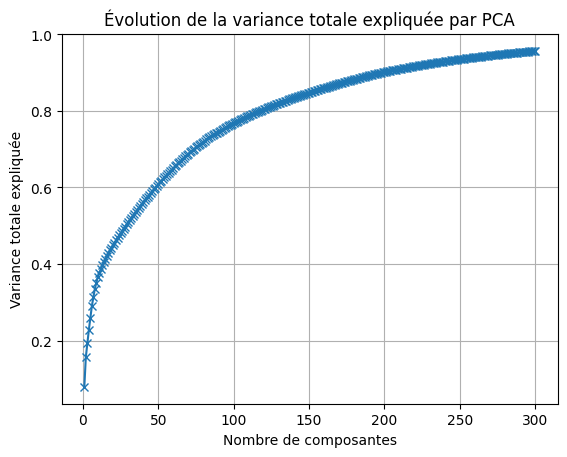

In [17]:
variance_expliquee = pca.explained_variance_ratio_
variance_cumulative = np.cumsum(variance_expliquee)

plt.plot(range(1, len(variance_cumulative) + 1), variance_cumulative, marker='x', linestyle='-')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance totale expliquée')
plt.title('Évolution de la variance totale expliquée par PCA')
plt.grid(True)
plt.show()

## Visualiation des données de test

In [18]:
x_test_pca = pca.transform(X_test)
noms_colonnes = [f'Composante_{i+1}' for i in range(X_train_pca.shape[1])]
X_test_pca = pd.DataFrame(x_test_pca, columns = noms_colonnes)


test_pca = pd.DataFrame(pca.transform(data_test_final), columns=noms_colonnes)

In [19]:
test_pca.shape

(25368, 10)

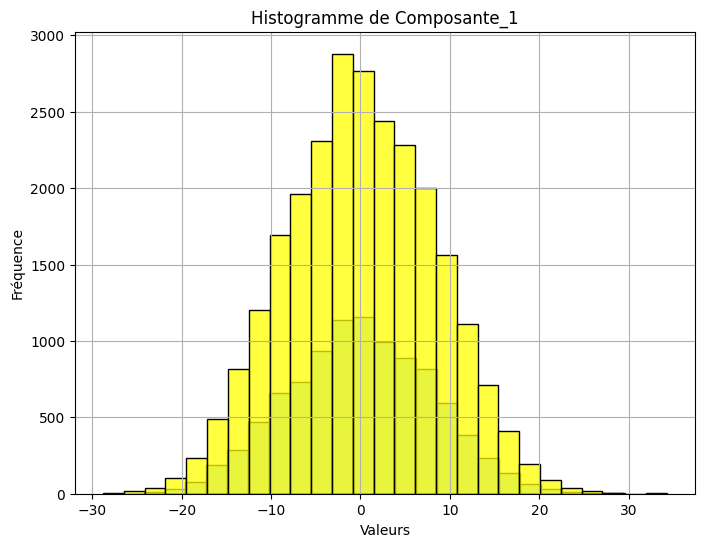

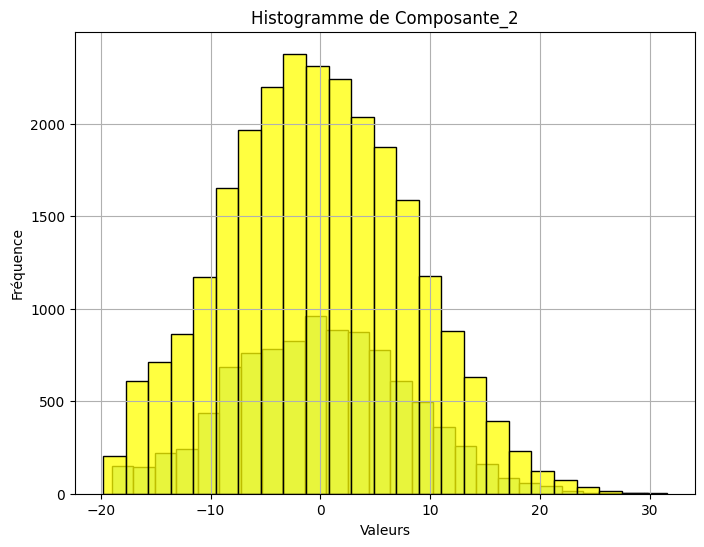

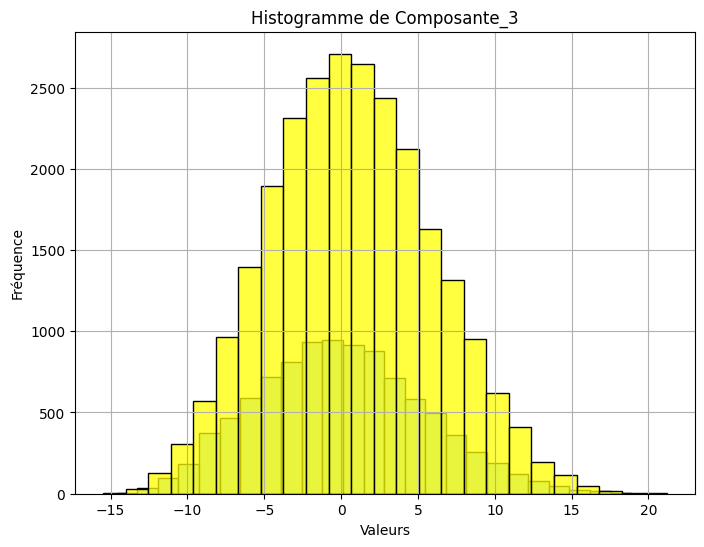

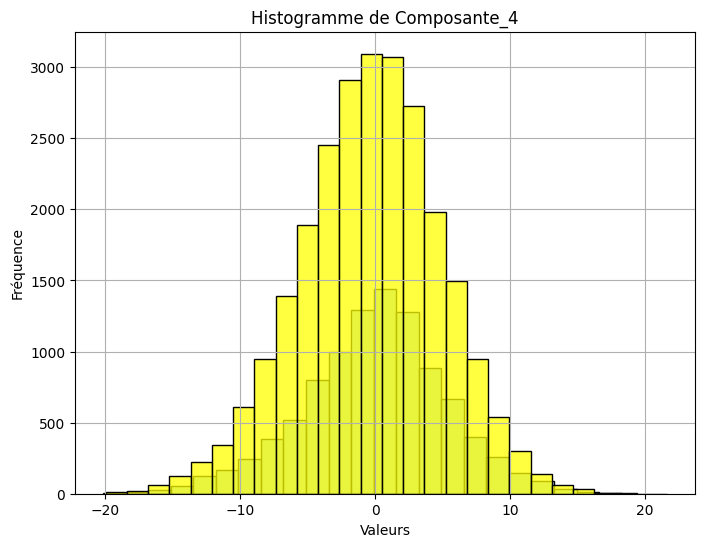

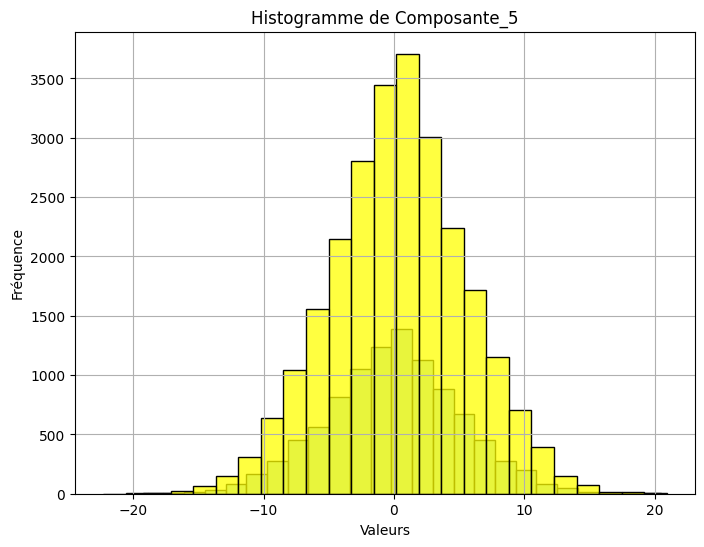

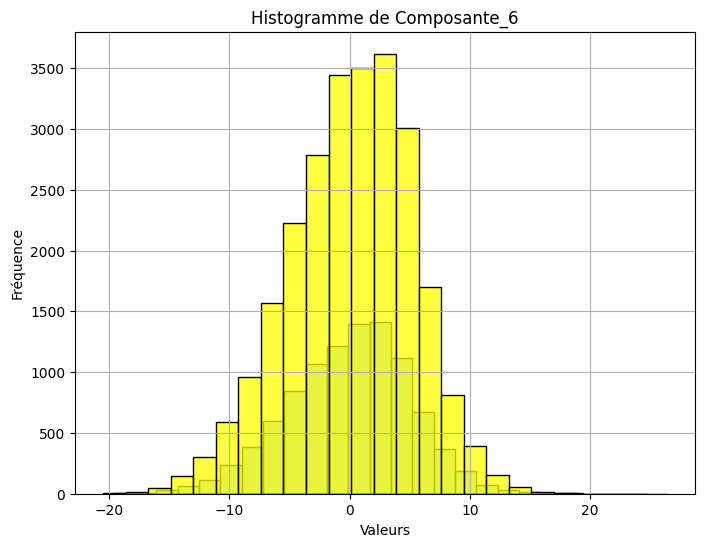

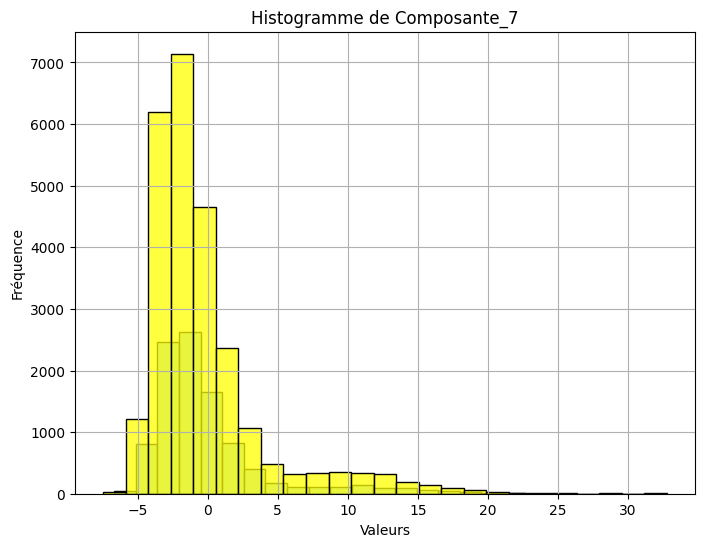

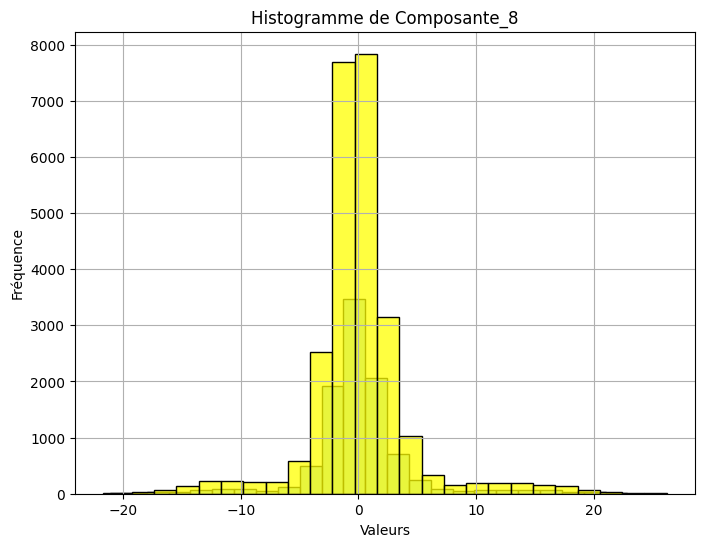

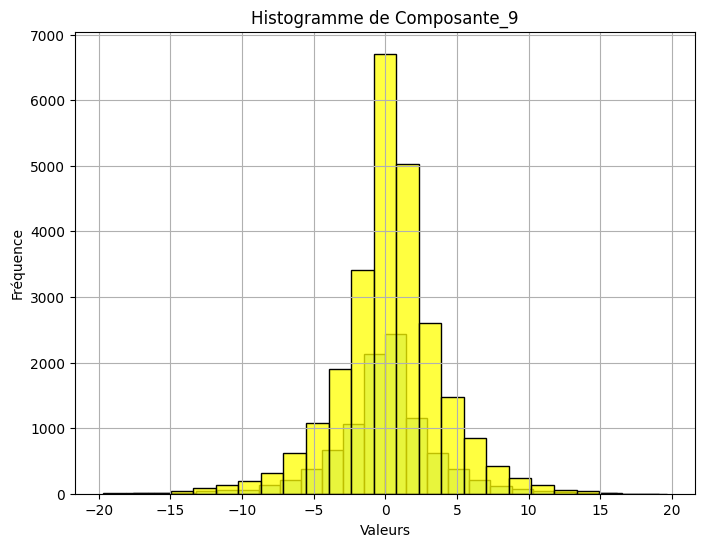

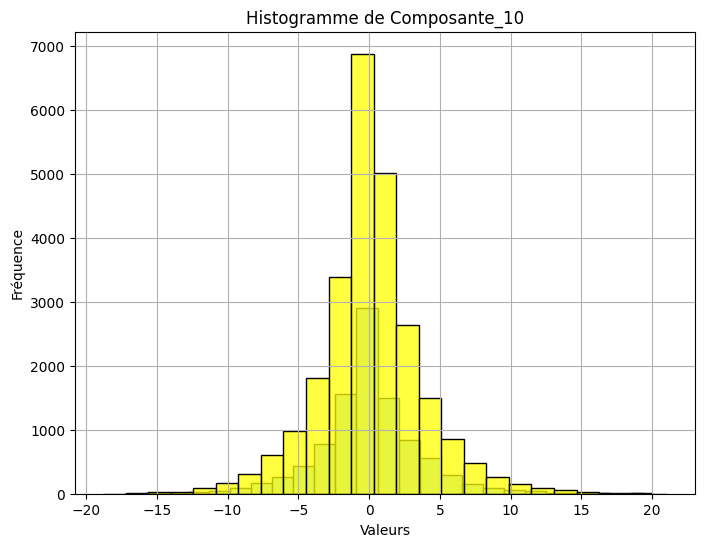

In [20]:
for colonne in test_pca.columns[:10]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=X_train_pca, x=colonne, bins=25, color='skyblue', edgecolor='black')
    sns.histplot(data=test_pca, x=colonne, bins=25, color='yellow', edgecolor='black')
    plt.title('Histogramme de ' + colonne)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

## Application de UMAP

In [22]:
umap = umap.UMAP()

In [23]:
X_train_umap = pd.DataFrame(umap.fit_transform(X_train), columns = [1,2])

X_test_umap = pd.DataFrame(umap.transform(X_test), columns = [1,2])

In [24]:
test_umap = pd.DataFrame(umap.transform(data_test_final), columns = [1,2])

In [25]:
X_train_umap.head()

,1,2
0,4.477612,5.173180
1,2.062338,5.633851
2,3.965139,2.618986
3,3.636668,0.265432
4,2.391506,1.246676


In [26]:
print(X_train_umap.shape)

(9842, 2)


TypeError: can only concatenate str (not "int") to str

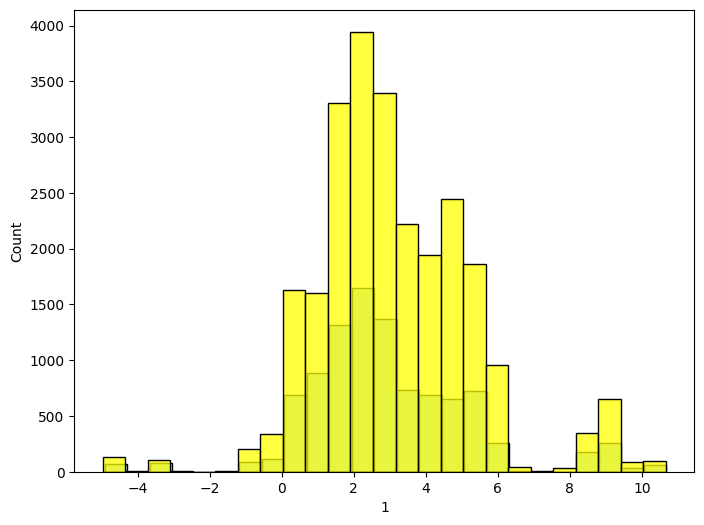

In [27]:
for colonne in [1,2]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=X_train_umap, x=colonne, bins=25, color='skyblue', edgecolor='black')
    sns.histplot(data=test_umap, x=colonne, bins=25, color='yellow', edgecolor='black')
    plt.title('Histogramme de ' + colonne)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

# Mise en place des modèles

## XGBoost

In [28]:
y_train_indices = np.argmax(y_train, axis=1)
y_test_indices = np.argmax(y_test, axis=1)
y_indices = np.argmax(y, axis = 1)

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

### Optimisation des hyperparamètres_PCA

In [37]:
def objective_pca(trial):

    params = {
        'objective': 'multi:softmax',
        'n_estimators': trial.suggest_int('n_estimators', 50,500),
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 3),
        'subsample': trial.suggest_float('subsample', 0.4, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.007, 0.06),
    }

    model = xgb.XGBClassifier(**params, random_state = 42)

    accuracy = cross_val_score(model, X_train_pca, y_train_indices, cv=5, scoring=make_scorer(accuracy_score)).mean()

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective_pca, n_trials=50)

[I 2024-04-16 17:54:56,849] A new study created in memory with name: no-name-25a834ec-78f2-4965-b99f-abe4234f0c91


[I 2024-04-16 17:54:59,631] Trial 0 finished with value: 0.4753108135449054 and parameters: {'n_estimators': 207, 'booster': 'gbtree', 'max_depth': 4, 'min_child_weight': 1.675636783023225, 'subsample': 0.6899535688536396, 'colsample_bytree': 0.9831085328337158, 'learning_rate': 0.056531455286521565}. Best is trial 0 with value: 0.4753108135449054.
[I 2024-04-16 17:55:04,135] Trial 1 finished with value: 0.47043364218558387 and parameters: {'n_estimators': 310, 'booster': 'gbtree', 'max_depth': 5, 'min_child_weight': 2.233738697103397, 'subsample': 0.6840330825684326, 'colsample_bytree': 0.6777697590509317, 'learning_rate': 0.04482706317104009}. Best is trial 0 with value: 0.4753108135449054.
[I 2024-04-16 17:55:07,654] Trial 2 finished with value: 0.4752102714018506 and parameters: {'n_estimators': 213, 'booster': 'gbtree', 'max_depth': 5, 'min_child_weight': 2.415932547478266, 'subsample': 0.6064319048601176, 'colsample_bytree': 0.8121669215672083, 'learning_rate': 0.0409105980886779

In [38]:
best_params_pca = study.best_params
print("Best params:", best_params_pca)

best_xgb_model = xgb.XGBClassifier(**best_params_pca, random_state = 42)
best_xgb_model.fit(X_train_pca, y_train_indices)
print(accuracy_score(y_test_indices,best_xgb_model.predict(X_test_pca)))

Best params: {'n_estimators': 58, 'booster': 'gbtree', 'max_depth': 4, 'min_child_weight': 1.9761868976584693, 'subsample': 0.6622296854917655, 'colsample_bytree': 0.9695248227664799, 'learning_rate': 0.01348459159983368}
0.4924827305973182


In [32]:
best_params = {'n_estimators': 141, 'booster': 'gbtree', 'max_depth': 4, 'min_child_weight': 1.2609573143807393, 'subsample': 0.4013051889767548, 'colsample_bytree': 0.8419442770556449, 'learning_rate': 0.013329501671057597}

best_xgb_model = xgb.XGBClassifier(**best_params, random_state = 42)
best_xgb_model.fit(X_train_pca, y_train_indices)
print(accuracy_score(y_test_indices,best_xgb_model.predict(X_test_pca)))

0.497765136123527


## Optimisation des hyperparamètres_UMAP

In [37]:
def objective_umap(trial):

    params = {
        'objective': 'multi:softmax',
        'n_estimators': trial.suggest_int('n_estimators', 50,500),
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 3),
        'subsample': trial.suggest_float('subsample', 0.4, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.007, 0.06),
    }

    model = xgb.XGBClassifier(**params, random_state = 42)

    model.fit(X_train_umap, y_train_indices)

    y_pred = model.predict(X_test_umap)

    accuracy = accuracy_score(y_test_indices, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective_umap, n_trials=50)

[I 2024-04-16 11:06:02,795] A new study created in memory with name: no-name-0653221a-68bb-4803-9197-8199f23c8303
[I 2024-04-16 11:06:03,498] Trial 0 finished with value: 0.42096708655018283 and parameters: {'n_estimators': 316, 'booster': 'gbtree', 'max_depth': 4, 'min_child_weight': 1.5821790781626095, 'subsample': 0.7090566837048211, 'colsample_bytree': 0.8419226700699104, 'learning_rate': 0.058139030703545556}. Best is trial 0 with value: 0.42096708655018283.
[I 2024-04-16 11:06:04,748] Trial 1 finished with value: 0.4124339699309224 and parameters: {'n_estimators': 483, 'booster': 'gbtree', 'max_depth': 6, 'min_child_weight': 2.7384779151193497, 'subsample': 0.5811971326647225, 'colsample_bytree': 0.5943981019686577, 'learning_rate': 0.03162459590918381}. Best is trial 0 with value: 0.42096708655018283.
[I 2024-04-16 11:06:05,347] Trial 2 finished with value: 0.431938236489232 and parameters: {'n_estimators': 242, 'booster': 'gbtree', 'max_depth': 6, 'min_child_weight': 2.44227315

# Application du modèle

In [190]:
test_pca.head()

,Composante_1,Composante_2,Composante_3,Composante_4,Composante_5,Composante_6,Composante_7,Composante_8,Composante_9,Composante_10,...,Composante_41,Composante_42,Composante_43,Composante_44,Composante_45,Composante_46,Composante_47,Composante_48,Composante_49,Composante_50
0,2.072932,-17.295405,-2.346271,-1.724870,5.838638,-1.492655,12.895737,-12.783460,0.030305,-0.674570,...,2.236875,5.530205,3.655739,-0.298892,0.187276,-1.550945,0.270380,-0.951928,-1.142809,2.213158
1,-7.556310,-10.998938,2.475158,5.375484,0.271807,-0.841559,5.593877,-4.561768,0.446219,-0.057689,...,2.087006,-0.808049,0.431106,3.129293,1.116430,1.246374,-1.033239,0.625224,-1.834713,1.497837
2,-10.149839,12.108570,2.679055,-6.040960,2.838260,4.900094,0.149142,3.967940,2.274523,-8.914615,...,2.612062,-0.767972,1.426334,-1.045371,0.586878,-2.412091,-1.616032,-1.050091,-0.502037,2.902904
3,-3.582773,-1.130221,2.374012,0.346055,-0.993911,-10.623445,-4.186622,-1.064136,-4.045566,3.066655,...,2.840625,-2.197186,1.674022,0.929253,-1.472621,0.421459,-0.868844,0.711729,0.017642,0.757536
4,12.963149,-3.814700,-2.124075,1.842750,4.178071,-9.367640,14.748763,17.385152,2.496143,3.528257,...,1.761059,0.322962,3.571900,0.372317,-0.405701,2.611390,-1.423860,2.145168,-2.474240,0.360869


In [40]:
results = []
res_pred = best_xgb_model.predict(test_pca)
res_proba = best_xgb_model.predict_proba(test_pca)

ID = train_index 

for res in res_pred:
    if res == 0 : 
        results.append([ID, 1, 0, 0])
    elif res == 1 : 
        results.append([ID, 0, 1, 0])
    elif res == 2 :
        results.append([ID, 0, 0, 1])
    ID += 1

results_test = pd.DataFrame(results, columns = ['ID', 'HOME_WINS', 'DRAW', 'AWAY_WINS'])

In [56]:
def metric(L, seuil1, seuil2, seuil3):
    if (L[1]>L[0] and L[1]>L[2]) or (L[1] > seuil1 and (L[0]<seuil2 and L[2]<seuil3)):
        return(1)
    elif L[0]>L[1] and L[0]>L[2] and not((L[1] > seuil1 and (L[0]<seuil2 and L[2]<seuil3))):
        return(0)
    elif L[2]>L[1] and L[2]>L[0] and not((L[1] > seuil1 and (L[0]<seuil2 and L[2]<seuil3))):
        return(2)
    

seuil1 = 0.3
seuil2 = 0.45
seuil3 = 0.3
res_pred_2 = list(map(lambda x : metric(x,seuil1, seuil2, seuil3),res_proba))

In [63]:
nb_trial = 3000
best_params_seuil = {}
best_accuracy = 0
y_test_proba = best_xgb_model.predict_proba(X_test_pca)

for i in range(nb_trial):
    seuil1 = np.random.uniform(0.2,0.5)
    seuil2 = np.random.uniform(0.2,0.5)
    seuil0 = np.random.uniform(0.2,0.5)
    y_pre = list(map(lambda x : metric(x,seuil0,seuil1,seuil2),y_test_proba))
    accuracy_test = accuracy_score(y_test_indices, y_pre)
    if accuracy_test > best_accuracy:
        best_params_seuil['seuil0'] = seuil0
        best_params_seuil['seuil1'] = seuil1
        best_params_seuil['seuil2'] = seuil2
        best_accuracy = accuracy_test

print(best_params_seuil, best_accuracy)

{'seuil0': 0.20591320081574505, 'seuil1': 0.2935066372752073, 'seuil2': 0.4106884482108186} 0.4937017472572125


In [69]:
seuil0 = best_params_seuil['seuil0'] 
seuil1 = best_params_seuil['seuil1'] 
seuil2 = best_params_seuil['seuil2'] 

res_pred_2 = list(map(lambda x : metric(x,seuil1, seuil2, seuil3),res_proba))

In [70]:
results_2 = []
for res in res_pred_2:
    if res == 0 : 
        results_2.append([ID, 1, 0, 0])
    elif res == 1 : 
        results_2.append([ID, 0, 1, 0])
    elif res == 2 :
        results_2.append([ID, 0, 0, 1])
    ID += 1

results_test_2 = pd.DataFrame(results_2, columns = ['ID', 'HOME_WINS', 'DRAW', 'AWAY_WINS'])

In [58]:
results_test_2.shape

(25368, 4)

In [68]:
results_test_2.to_csv("C:/Users/alqui/Downloads/XGBoost_PCA10_treshold.csv", index = False)

## Visualisation des résultats

C:\Users\alqui\AppData\Local\Temp\ipykernel_29176\1282856888.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(targets)


Text(0, 0.5, 'Count')

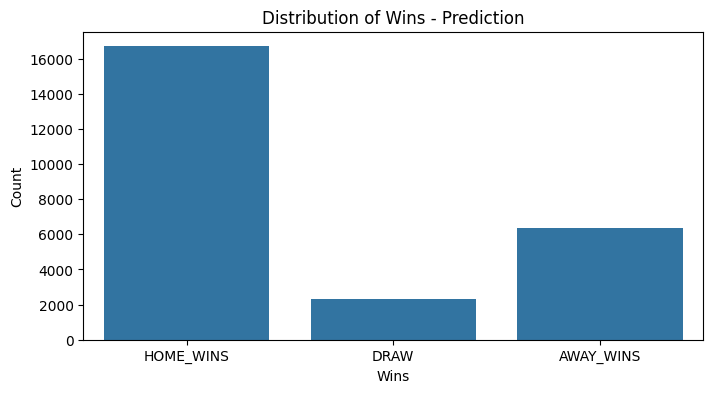

In [71]:
targets = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

targets_bin_pred = results_test_2[targets]
target_pred = targets_bin_pred@(np.arange(targets_bin_pred.shape[1]) + 1)
target_pred[targets_bin_pred.sum(axis=1)==2] = 3

plt.figure(figsize=(8, 4))
ax = sns.countplot(x=target_pred)
ax.set_xticklabels(targets) 

plt.title('Distribution of Wins - Prediction')
plt.xlabel('Wins')
plt.ylabel('Count')


In [42]:
results_test['DRAW'].sum()

10

## Visualisation des erreurs de prédiction

In [65]:
def evaluate_pred(y_pred, y_test , y_prob) :
    y_test_index = y_test.shape[0]
    evaluation_pred = {}
    prob = {'0_1':[], '0_2':[], '1_2':[], '1_0':[], '2_1':[],'2_0':[], '0':[], '1':[], '2':[]}
    ind = {'0_1':[], '0_2':[], '1_2':[], '1_0':[], '2_1':[],'2_0':[], '0':[], '1':[], '2':[]}
    evaluation_pred['0'] = 0
    evaluation_pred['1'] = 0
    evaluation_pred['2'] = 0
    evaluation_pred['0_1'] = 0     # prédiction de 1 au lieu de 0
    evaluation_pred['0_2'] = 0
    evaluation_pred['1_2'] = 0
    evaluation_pred['1_0'] = 0
    evaluation_pred['2_0'] = 0
    evaluation_pred['2_1'] = 0
    for index in range(y_test_index):
        if y_test[index] == y_pred[index]:
            if y_test[index] == 0 :
                evaluation_pred['0'] +=1
                prob['0'].append(y_prob[index][0])
                ind['0'].append(index)
            elif y_test[index] == 1 :
                evaluation_pred['1'] +=1
                prob['1'].append(y_prob[index][1])
                ind['1'].append(index)
            elif y_test[index] == 2 :
                evaluation_pred['2'] +=1
                prob['2'].append(y_prob[index][2])
                ind['2'].append(index)
        else : 
            if y_test[index] == 0 :
                if y_pred[index] == 1:
                    prob['0_1'].append(y_prob[index][1])
                    evaluation_pred['0_1'] +=1
                    ind['0_1'].append(index)
                if y_pred[index] == 2:
                    prob['0_2'].append(y_prob[index][2])
                    evaluation_pred['0_2'] +=1
                    ind['0_2'].append(index)
            elif y_test[index] == 1 :
                if y_pred[index] == 0:
                    prob['1_0'].append(y_prob[index][0])
                    evaluation_pred['1_0'] +=1
                    ind['1_0'].append(index)
                if y_pred[index] == 2:
                    prob['1_2'].append(y_prob[index][2])
                    ind['1_2'].append(index)
                    evaluation_pred['1_2'] +=1
            elif y_test[index] == 2 :
                if y_pred[index] == 1:
                    prob['2_1'].append(y_prob[index][1])
                    evaluation_pred['2_1'] +=1
                    ind['2_1'].append(index)
                if y_pred[index] == 0:
                    prob['2_0'].append(y_prob[index][0])
                    ind['2_0'].append(index)
                    evaluation_pred['2_0'] +=1

    return(evaluation_pred,prob,ind)

In [66]:
y_pred = best_xgb_model.predict(X_test_pca)
y_prob = best_xgb_model.predict_proba(X_test_pca)
eval_pred, prob_dict, ind_dict = evaluate_pred(y_pred,y_test_indices,y_prob)

print(len(prob_dict['1']),eval_pred['1'])

0 0


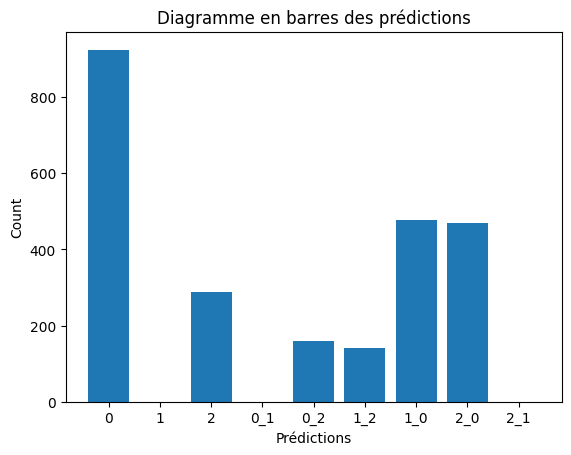

In [67]:
cles = list(eval_pred.keys())
valeurs = list(eval_pred.values())

plt.bar(cles, valeurs)

plt.xlabel('Prédictions')
plt.ylabel('Count')
plt.title('Diagramme en barres des prédictions')

plt.show()

In [34]:
print(categories.remove('1_2').remove('0').remove('2_1'))

ValueError: list.remove(x): x not in list

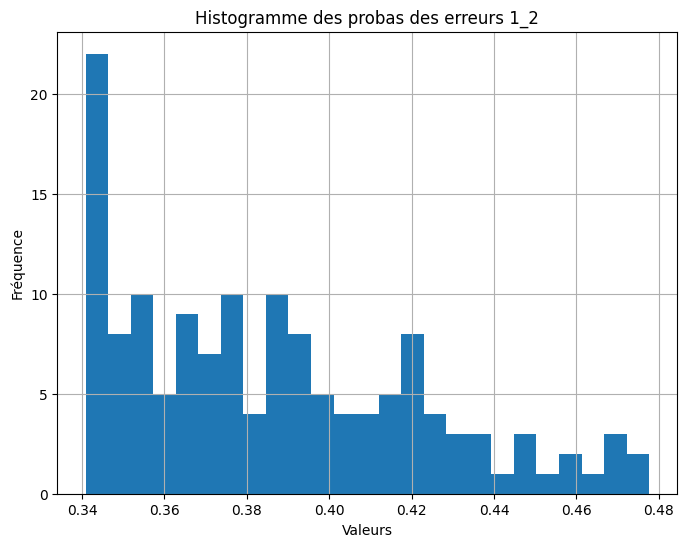

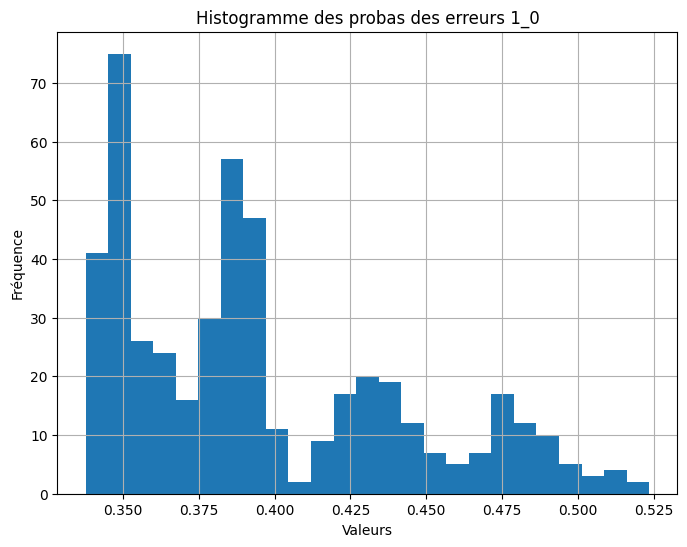

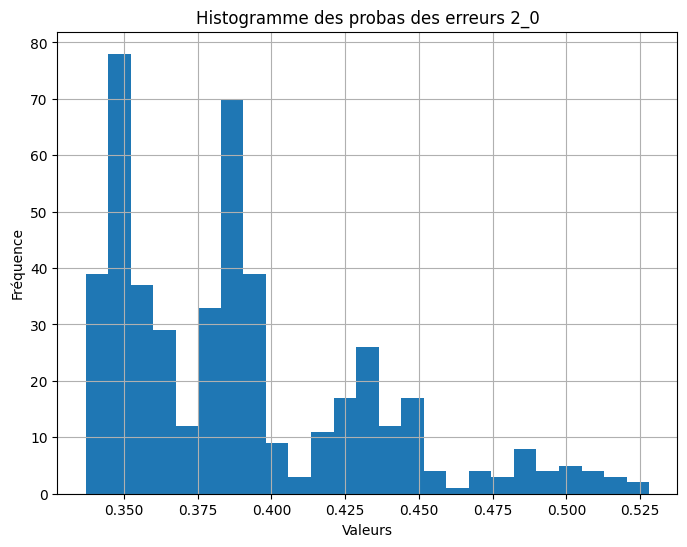

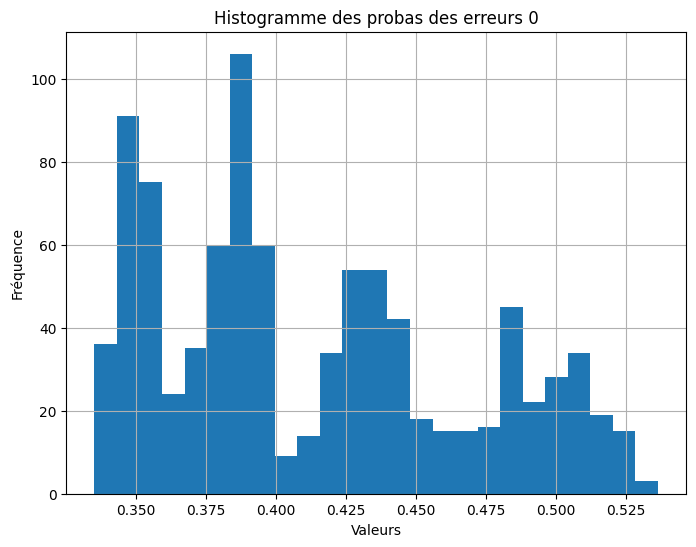

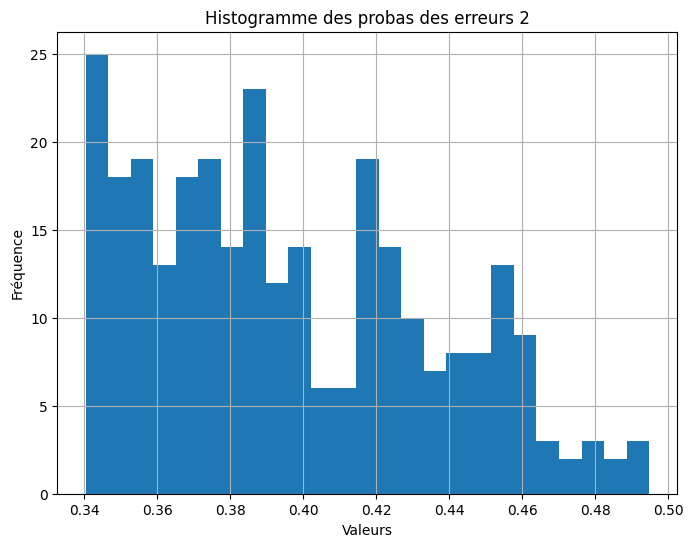

In [46]:
categories = list(prob_dict.keys())
L=['0_2','0_1','1','2_1']
for l in L:
    categories.remove(l)

for cat in categories:
    plt.figure(figsize=(8, 6))
    plt.hist(prob_dict[cat], bins = 25)
    plt.title('Histogramme des probas des erreurs ' + cat)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

In [79]:
print(max(ind_dict['1_0']))

2460


On trace ici la répartition de deux groupes : les vrais gagnant à la maison et ceux qui étaient prédits gagnants à la maison mais qui ont fait nul

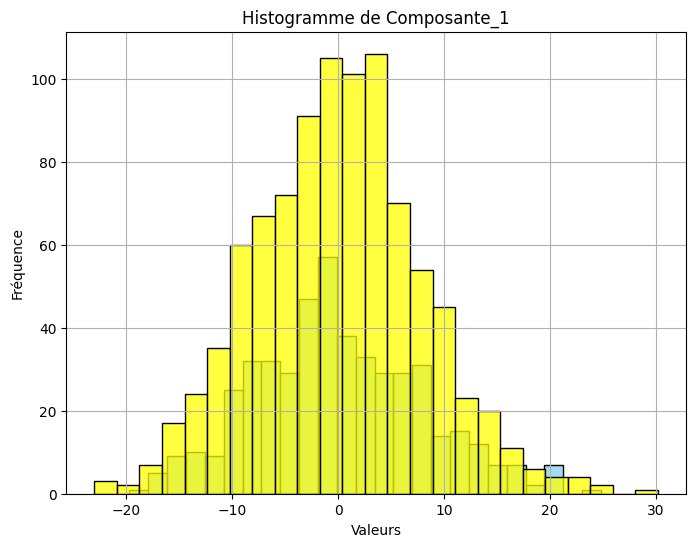

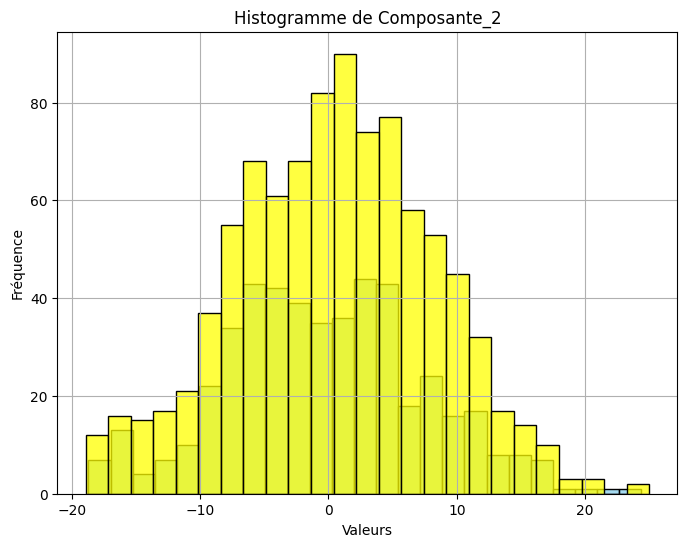

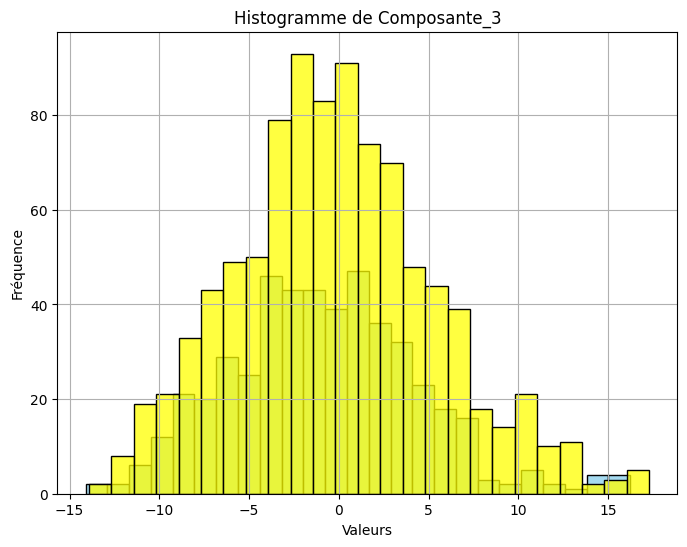

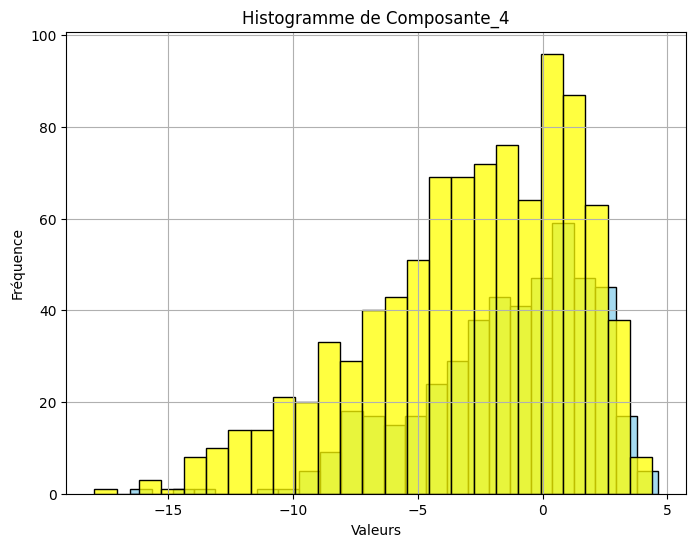

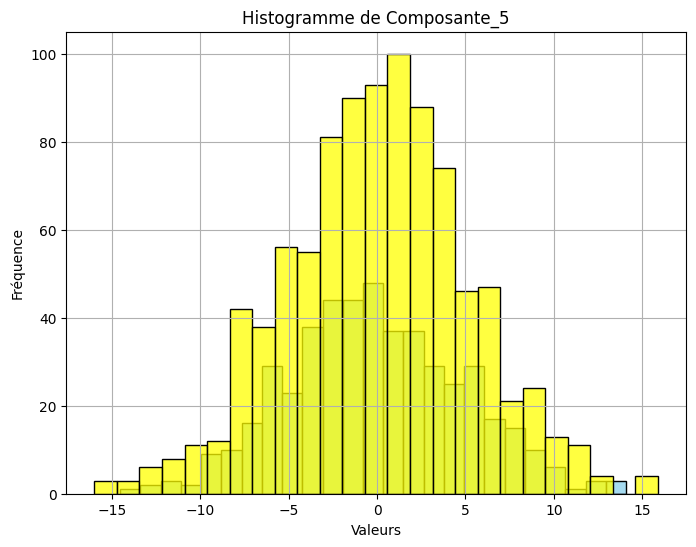

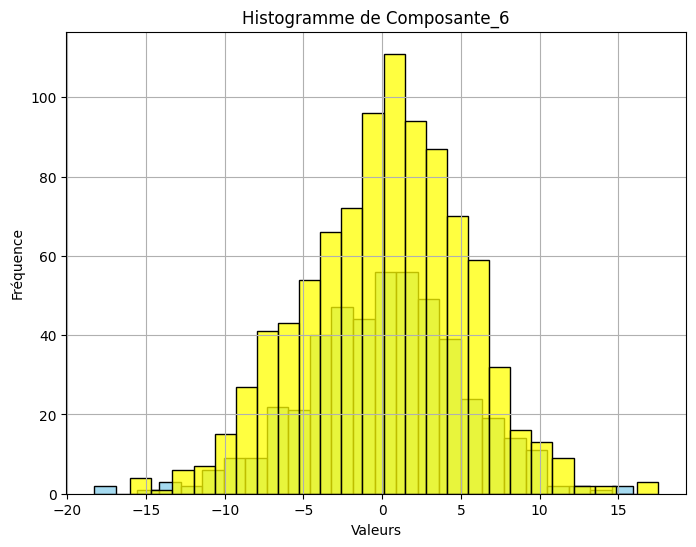

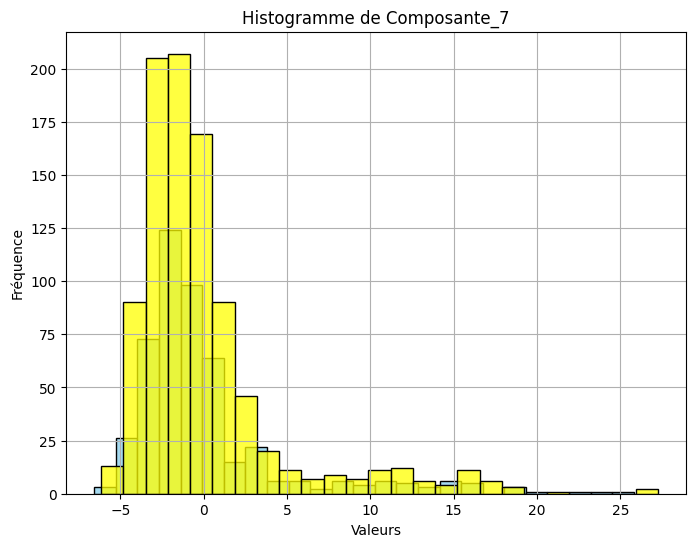

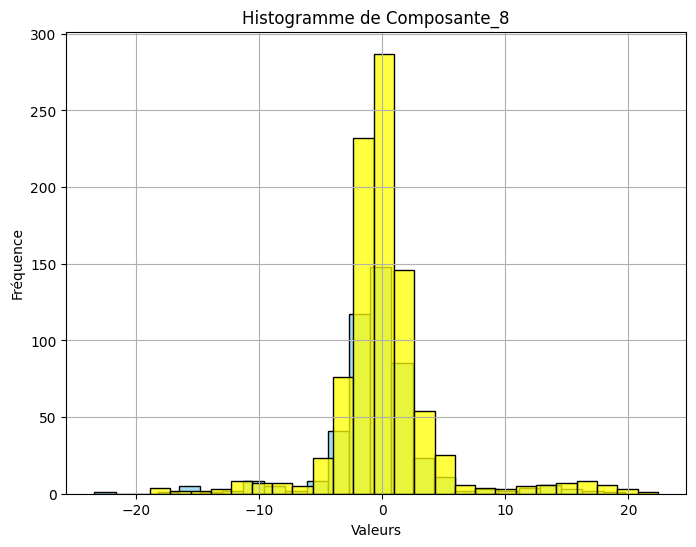

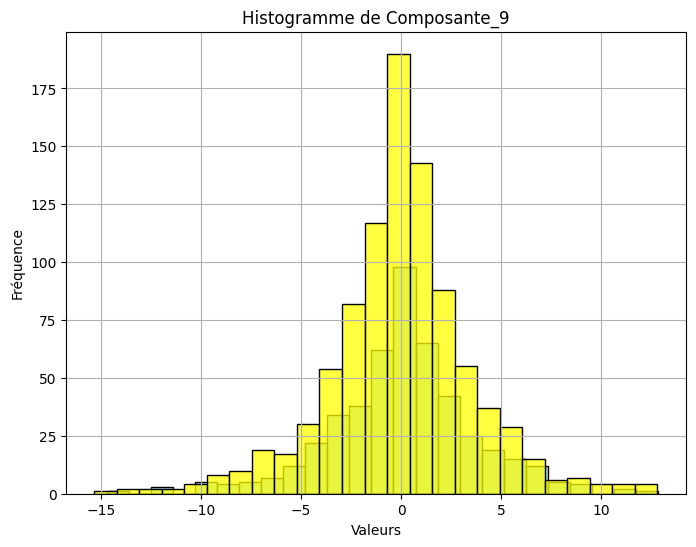

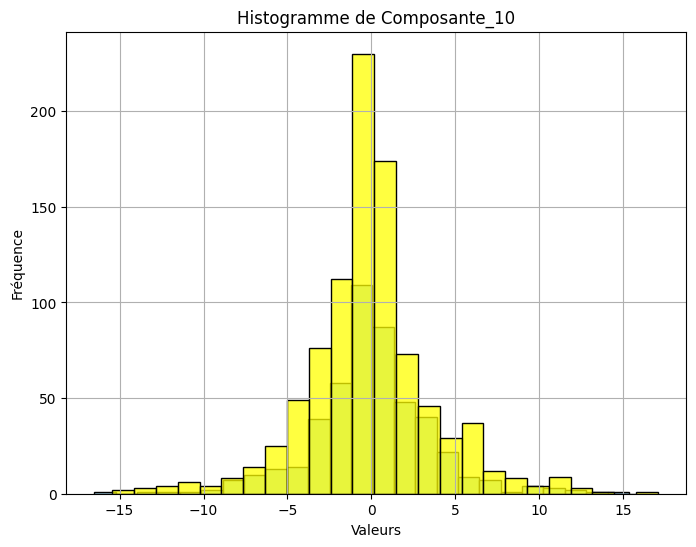

In [86]:
df_1_0 = X_test_pca.loc[ind_dict['1_0']]
df_0 = X_test_pca.loc[ind_dict['0']]

for colonne in X_test_pca.columns[:10]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_1_0, x=colonne, bins=25, color='skyblue', edgecolor='black')
    sns.histplot(data=df_0, x=colonne, bins=25, color='yellow', edgecolor='black')
    plt.title('Histogramme de ' + colonne)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

On réalise la même chose mais pour les équipes gagnantes à l'extérieur

In [ ]:
df_1_2 = X_test_pca.loc[ind_dict['1_2']]
df_2 = X_test_pca.loc[ind_dict['2']]

for colonne in X_test_pca.columns[:10]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_2, x=colonne, bins=25, color='skyblue', edgecolor='black')
    sns.histplot(data=df_1_2, x=colonne, bins=25, color='yellow', edgecolor='black')
    plt.title('Histogramme de ' + colonne)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

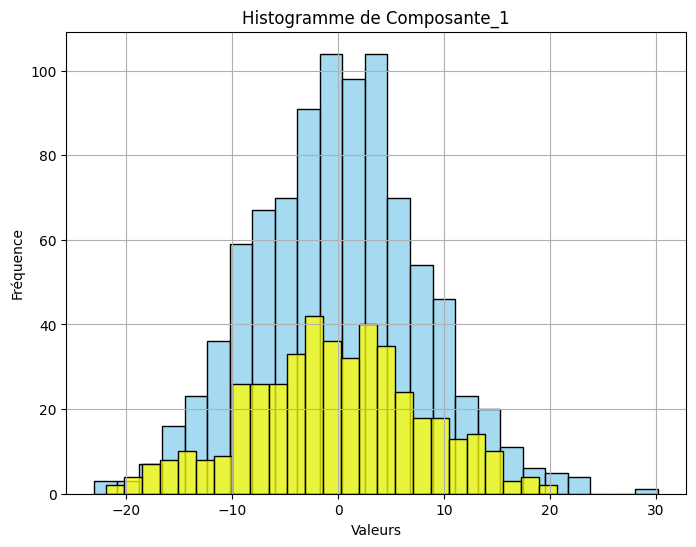

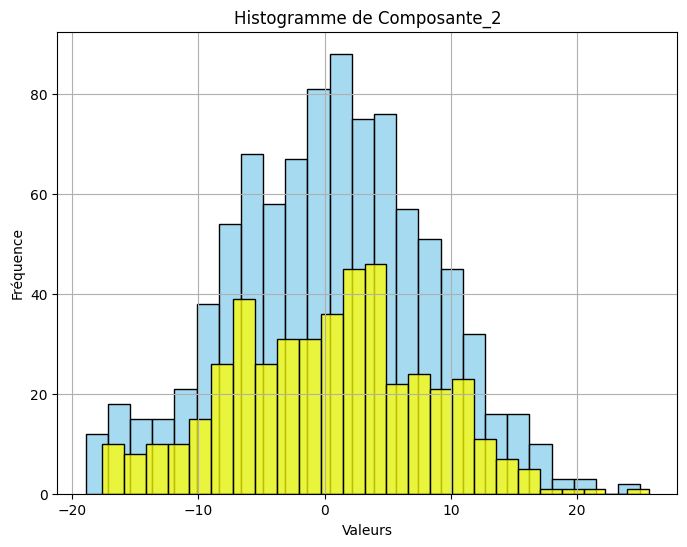

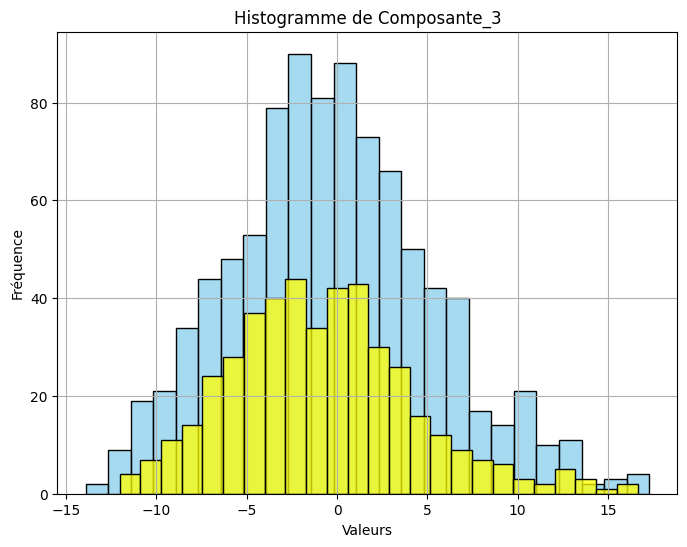

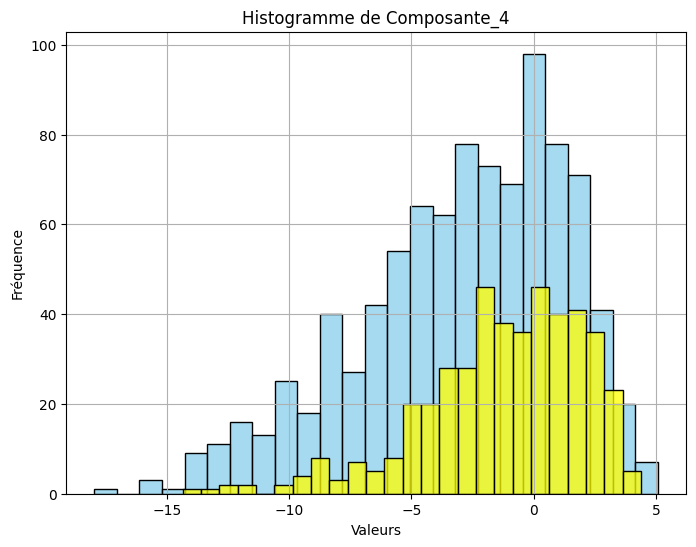

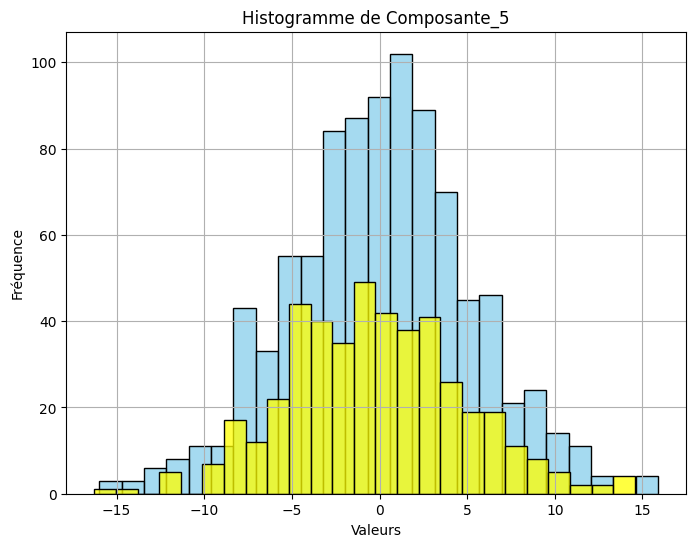

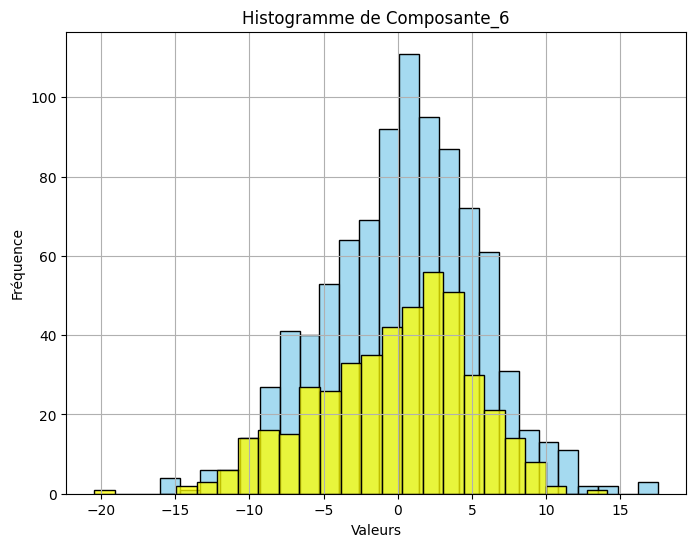

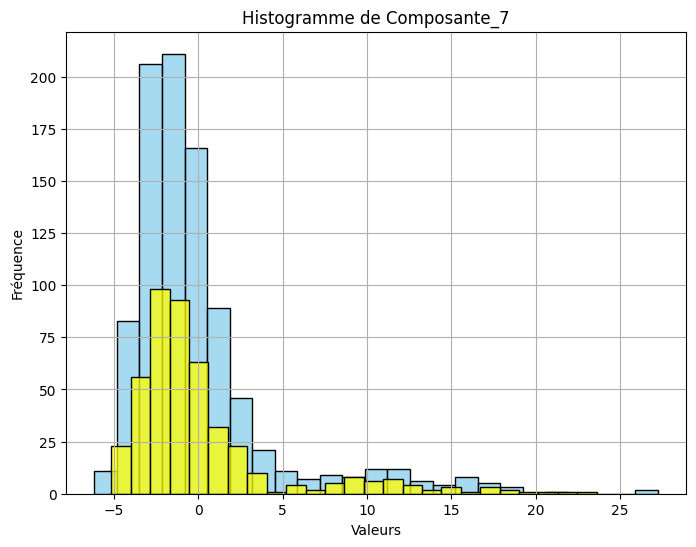

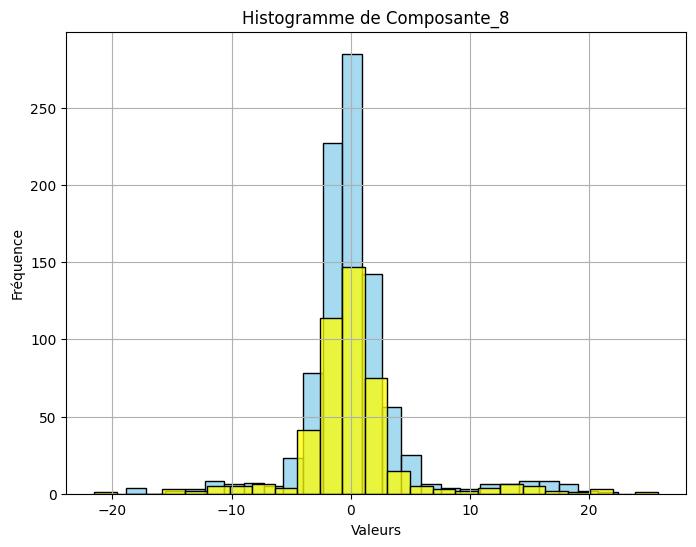

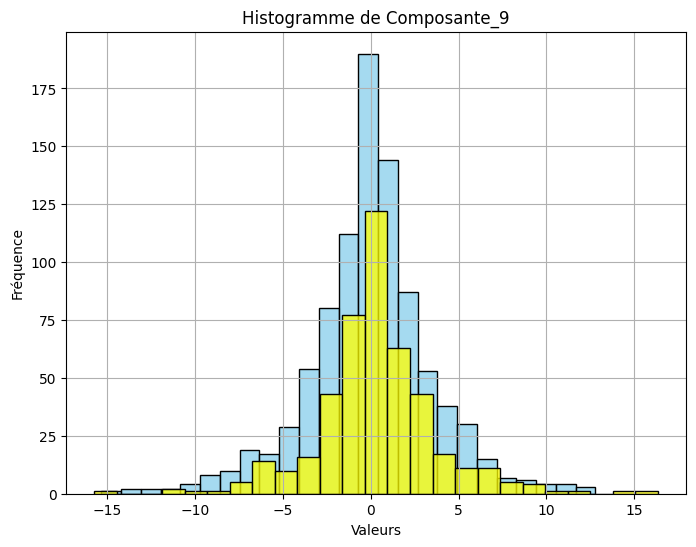

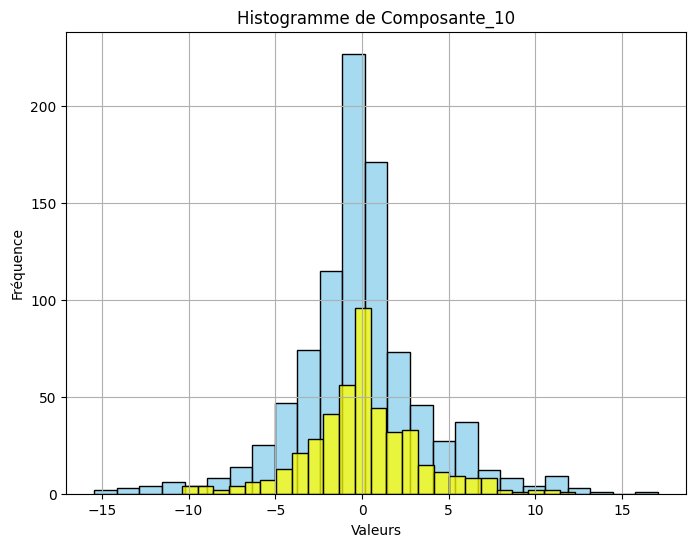

In [54]:
df_2_0 = X_test_pca.loc[ind_dict['2_0']]
df_0 = X_test_pca.loc[ind_dict['0']]

for colonne in X_test_pca.columns[:10]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_0, x=colonne, bins=25, color='skyblue', edgecolor='black')
    sns.histplot(data=df_2_0, x=colonne, bins=25, color='yellow', edgecolor='black')
    plt.title('Histogramme de ' + colonne)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()